In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import DistanceMetric
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import umap

%load_ext autoreload
%autoreload 2

# 1. Read data

In [2]:
df_train_raw = pd.read_csv('./data/transformed/adult_train.csv',
                    sep=',',
                    engine='python')

df_test_raw = pd.read_csv('./data/transformed/adult_test.csv',
                    sep=',',
                    engine='python')

# 2. Generate counterfactuals
- Baseline: just flip gender attribute

In [3]:
def generate_cf_baseline(df):
    df_copy = df.copy()
    df_copy['sex'] = df_copy['sex'].replace({'Male': 'Female', 'Female': 'Male'})
    return df_copy

df_cf_train_raw = generate_cf_baseline(df_train_raw)
df_cf_test_raw = generate_cf_baseline(df_test_raw)

In [4]:
# Assert the sex column has been swapped successfully 
assert (df_cf_train_raw['sex'] == df_train_raw['sex'].replace({'Male': 'Female', 'Female': 'Male'})).all(), "Sex column swap failed for train data."
assert (df_cf_test_raw['sex'] == df_test_raw['sex'].replace({'Male': 'Female', 'Female': 'Male'})).all(), "Sex column swap failed for test data."

# 3. Transform data

In [16]:
class DataPreprocessor:
    def __init__(self, numerical_cols, categorical_cols):
        self.numerical_cols = numerical_cols
        self.categorical_cols = categorical_cols
        self.scaler = MinMaxScaler()

    def preprocess(self, df):
        df[self.numerical_cols] = self.scaler.fit_transform(df[self.numerical_cols])
        new_dummy_cols = pd.get_dummies(df, columns=self.categorical_cols).columns.difference(df.columns)
        df = pd.get_dummies(df, columns=self.categorical_cols)
        df[new_dummy_cols] = df[new_dummy_cols].astype(int)
        return df

    def inverse_preprocess(self, df):
        # Reverse one-hot encoding
        for col in self.categorical_cols:
            one_hot_cols = [c for c in df.columns if c.startswith(col + '_')]
            df[col] = df[one_hot_cols].idxmax(axis=1).apply(lambda x: x[len(col) + 1:])
            df.drop(columns=one_hot_cols, inplace=True)
        
        df[self.numerical_cols] = self.scaler.inverse_transform(df[self.numerical_cols])
        return df

categorical_cols = df_train_raw.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_train_raw.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = DataPreprocessor(numerical_cols, categorical_cols)

df_test = preprocessor.preprocess(df_test_raw)
df_train = preprocessor.preprocess(df_train_raw)
df_cf_train = preprocessor.preprocess(df_cf_train_raw)
df_cf_test = preprocessor.preprocess(df_cf_test_raw)

# 4. Evaluate counterfactuals

## 4.1 Calculate distance from original samples

In [22]:
from utils.distance import calculate_pairwise_distance

euclidean_distance = calculate_pairwise_distance(df_train, df_cf_train, 'euclidean')
manhattan_distance = calculate_pairwise_distance(df_train, df_cf_train, 'manhattan')
chebyshev_distance = calculate_pairwise_distance(df_train, df_cf_train, 'chebyshev')
cosine_distance = calculate_pairwise_distance(df_train, df_cf_train, 'cosine')

: 

In [13]:
euclidean_distance

array([0., 0., 0., ..., 0., 0., 0.])

<Axes: >

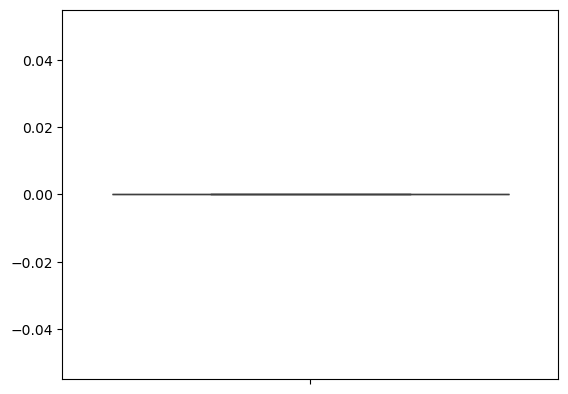

In [ ]:
sns.boxplot(euclidean_distance)
# sns.histplot(chebyshev_distance, bins=50, kde=True)
# sns.histplot(cosine_distance, bins=50, kde=True)